# Assignment 4

### 1. 复习上课内容以及复现课程代码

在本部分，你需要复习上课内容和课程代码后，自己复现课程代码。

In [14]:
import numpy as np


class Node:
    
    def __init__(self, inputs=[]):
        
        self.inputs = inputs
        self.outputs = []
        
       
        for n in self.inputs:
            n.outputs.append(self)
            

        self.value = None
        
        self.gradients = {}
        
        

    def forward(self):
       

        raise NotImplemented
    

    def backward(self):
        

        raise NotImplemented
        
class Input(Node):
    
    def __init__(self):
       
        Node.__init__(self)

    def forward(self, value=None):
        
        
        if value is not None:
            self.value = value
            
        
    def backward(self):
        
        self.gradients = {self:0}  
        for n in self.outputs:
            
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
        
        


class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
       

class Linear(Node):
    
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            
            grad_cost = n.gradients[self]
            
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

class Sigmoid(Node):
    
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        
        self.x = self.inputs[0].value  
        self.value = self._sigmoid(self.x)

    def backward(self):
        
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            



class MSE(Node):
    
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):
   
    for n in graph:
        n.forward()
        

    for n in  graph[::-1]:
        n.backward()

    

def topological_sort(feed_dict):


    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def sgd_update(trainables, learning_rate=1e-2):

    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [19]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample

losses = []

data = load_boston()
X_ = data['data']
y_ = data['target']


X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)


X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000

m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))


for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        
        
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        
        X.value = X_batch
        y.value = y_batch

        
        _ = None
        forward_and_backward(_, graph) 

        
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 147.089
Epoch: 101, Loss: 6.751
Epoch: 201, Loss: 4.151
Epoch: 301, Loss: 4.226
Epoch: 401, Loss: 3.776
Epoch: 501, Loss: 3.726
Epoch: 601, Loss: 3.963
Epoch: 701, Loss: 3.924
Epoch: 801, Loss: 3.862
Epoch: 901, Loss: 3.069
Epoch: 1001, Loss: 3.772
Epoch: 1101, Loss: 3.621
Epoch: 1201, Loss: 3.528
Epoch: 1301, Loss: 3.273
Epoch: 1401, Loss: 3.789
Epoch: 1501, Loss: 3.329
Epoch: 1601, Loss: 3.470
Epoch: 1701, Loss: 3.118
Epoch: 1801, Loss: 2.609
Epoch: 1901, Loss: 2.882
Epoch: 2001, Loss: 3.333
Epoch: 2101, Loss: 3.255
Epoch: 2201, Loss: 2.893
Epoch: 2301, Loss: 2.740
Epoch: 2401, Loss: 2.767
Epoch: 2501, Loss: 3.237
Epoch: 2601, Loss: 3.002
Epoch: 2701, Loss: 3.292
Epoch: 2801, Loss: 3.060
Epoch: 2901, Loss: 3.211
Epoch: 3001, Loss: 2.945
Epoch: 3101, Loss: 2.947
Epoch: 3201, Loss: 3.198
Epoch: 3301, Loss: 3.214
Epoch: 3401, Loss: 2.442
Epoch: 3501, Loss: 2.896
Epoch: 3601, Loss: 2.675
Epoch: 3701, Loss: 2.861
Epoch: 3801, Loss: 2.656
Epoc

In [17]:
def forward(outputNode,graph):
    for n in graph:
        n.forward()
    return outputNode.value

In [18]:
forward(l2,graph)

array([[13.15730968],
       [20.83135256],
       [22.16365693],
       [26.97502135],
       [34.40434781],
       [18.59721228],
       [24.34152572],
       [49.59313391],
       [21.53991083],
       [16.48787568],
       [21.91378791],
       [31.80050443],
       [15.09614017],
       [38.8338202 ],
       [24.51164553],
       [19.22698949]])

### 2. 回答一下理论题目

#### 1. What does a neuron compute?

神经元可以看作一个计算与存储单元。计算是神经元对其的输入进行计算功能。存储是神经元会暂存计算结果，并传递到下一层。

####  2. Why we use non-linear activation funcitons in neural networks?

如果使用线性激活函数，那么这个模型的输出不过是你输入特征x的线性组合。神经网络只是把输入线性组合再输出。
所以即使你有很多个隐含层，但是你如果使用线性激活函数或者不用激活函数，一直在做的只是计算线性激活函数，
非线性保证层数有意义

#### 3. What is the 'Logistic Loss' ?

Logistic Loss是交叉熵在二分类下的特殊情况

#### 4. Assume that you are building a binary classifier for detecting if an image containing cats, which activation functions would you recommen using for the output layer ?

A. ReLU    
B. Leaky ReLU    
C. sigmoid    
D. tanh  

C：二分类情况下可用sigmoid，因为二元分类的标签 yyy 要么是 0，要么是 1，所以我们希望输出值能表示当前样本属于某类别的概率，而概率又介于 0 和 1 之间，这恰好和 sigmoid 函数的值域相符。所以在做二元分类的时候，输出层的激活函数可以选择 sigmoid

#### 5. Why we don't use zero initialization for all parameters ?

所有参数零初始化会导致正向传播的值和反向传播梯度一样，每个神经元的值都一样，会有神经网络对称问题

#### 6. Can you implement the softmax function using python ? 

In [117]:
import numpy as np
def softmax(z):
    z = np.array(z)
    z = z - max(z)
    z = np.exp(z)   #求e^zi值
    softmax_z = z / np.sum(z)
    return softmax_z


### 3.实践题

#### In this practical part, you will build a simple digits recognizer to check if the digit in the image is larger than 5. This assignmnet will guide you step by step to finish your first small project in this course .

#### 1 - Packages  
sklearn is a famous package for machine learning.   
matplotlib is a common package for vasualization.

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### 2 - Overvie of the dataset  
    - a training set has m_train images labeled as 0 if the digit < 5 or 1 if the digit >= 5
    - a test set contains m_test images labels as if the digit < 5 or 1 if the digit >= 5
    - eah image if of shape (num_px, num_px ). Thus, each image is square(height=num_px and  width = num_px)

In [2]:
# Loading the data 
digits = datasets.load_digits()

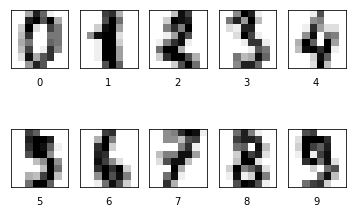

In [3]:
# Vilizating the data
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [4]:
# Split the data into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)

In [5]:
# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.

y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1

In [6]:
X_train = X_train.T
X_test = X_test.T
y_train = y_train.T
y_test = y_test.T

In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(64, 1347)
(64, 450)
(1347,)
(450,)


#### 3- Architecture of the neural network

![title](./networks.png)

In [4]:
!pwd

/Users/limingxiao/Desktop/NLP_Lectures/jupyters_and_slides/2019-spring


##### Mathematical expression of the algorithm:

For one example $x^{(i)}$:   
 $$ z^{(i)} = w^T * x^{(i)} +b $$   
 $$ y^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$   
 $$L(a^{(i)},y^{(i)}) = -y^{(i)} log(a^{(i)})-(1-y^{(i)})log(1-a^{(i)})$$

The total cost over all training examples:
$$ J = \frac{1}{m}\sum_{i=1}^{m}L(a^{(i)},y^{(i)}) $$

#### 4 - Building the algorithm

##### 4.1- Activation function    
###### Exercise:
Finish the sigmoid funciton 

In [16]:
import numpy as np
def sigmoid(z):
    '''
    Compute the sigmoid of z
    Arguments: z -- a scalar or numpy array of any size.
    
    Return:
    s -- sigmoid(z)
    '''
    s = 1/(1 + np.exp(-1 * z))
    
    return s

In [9]:
# Test your code 
# The result should be [0.5 0.88079708]
print("sigmoid([0,2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0,2]) = [0.5        0.88079708]


##### 4.1-Initializaing parameters
###### Exercise:
Finishe the initialize_parameters function below

In [90]:
# Random innitialize the parameters

def initialize_parameters(dim):
    '''
    Argument: dim -- size of the w vector
    
    Returns:
    w -- initialized vector of shape (dim,1)
    b -- initializaed scalar
    '''
    #f = X_train.shape[1]
    w = np.zeros((dim,1))
    b = 0
    
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return w,b

#### 4.3-Forward and backward propagation

###### Some mathematical expressions
Forward Propagation:   
. X    
. A = $\sigma(w^T*X+b) = (a^{(1)},a^{(2)},...,a^{(m)}$   
. J = $-\frac{1}{m} \sum_{i=1}^{m}y^{(i)}log(a^{(i)}+(1-y^{(i)})log(1-a^{(i)})$       

Some derivative: 
$$\frac{\partial{J}}{\partial{w}} = \frac{1}{m}X*(A-Y)^T$$   
$$\frac{\partial{J}}{\partial{b}} = \frac{1}{m}\sum_{i=1}^m(a^{(i)}-y^{(i)}) $$

###### Exercise:
Finish the function below:

In [65]:
def propagate(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
    
    m = X.shape[1]
    
    A = sigmoid(np.dot(w.T,X)+b)
    
    cost = -np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))*1/m
    #print('cost:',cost)
    dz = A-Y
    #print('dz:',dz)
    dw = np.dot(X,dz.T)/m
    db = np.sum(A-Y)/m
    
    #print('dw:',dw)
   #print('w:',w.T)
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    #cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

##### 4.4 -Optimization

###### Exercise:
Minimizing the cost function using gradient descent.   
$$\theta = \theta - \alpha*d\theta$$ where $\alpha$ is the learning rate.

In [9]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    
    costs = []
    a = learning_rate
    for i in range(num_iterations):
        
        grads,cost = propagate(w,b,X,Y)
        
        dw = grads['dw']
        db = grads['db']
        
        w = w- a*dw
        b = b- a*db
        
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
    
    return params, grads, costs

###### Exercise
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function.    
Two steps to finish this task:   
1. Calculate $\hat{Y} = A = \sigma(w^T*X+b)$   
2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [101]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)
    
    A = sigmoid(np.dot(w.T,X)+b)
    for i in range(A.shape[1]):
        if A[0,i]<0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

##### 5- Merge all functions into a model

Congratulations !! You have finished all the necessary components for constructing a model. Now, Let's take the challenge to merge all the implemented function into one model.

In [112]:
def model(X_train, Y_train,X_test, Y_test):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
    dim = X_train.shape[0]
    w,b = initialize_parameters(dim)
        
    params,grads,costs = optimize(w,b,X_train,Y_train,1000,0.001,True)
    w = params['w']
    b = params['b']
    Y_predict_train = predict(w,b,X_train)
    Y_predict_test = predict(w,b,X_test)
    training_accuracy = 100-np.mean(np.abs(Y_predict_train-Y_train))*100
    test_accuracy = 100-np.mean(np.abs(Y_predict_test-Y_test))*100
    print('training_accuracy:{}%'.format(training_accuracy))
    print('test_accuracy:{}%'.format(test_accuracy))
    d = {
        'w':w,
        'b':b,
        'training_accuracy':training_accuracy,
        'test_accuracy':test_accuracy,
        'costs':costs
    }
    return d

In [113]:
model(X_train, y_train,X_test,y_test)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.410310
Cost after iteration 200: 0.349368
Cost after iteration 300: 0.320535
Cost after iteration 400: 0.302889
Cost after iteration 500: 0.290671
Cost after iteration 600: 0.281586
Cost after iteration 700: 0.274513
Cost after iteration 800: 0.268827
Cost after iteration 900: 0.264148
training_accuracy:90.42316258351893%
test_accuracy:87.77777777777777%


{'w': array([[ 0.00000000e+00],
        [-9.11574535e-03],
        [-2.32621542e-04],
        [-4.90218838e-03],
        [ 1.95273038e-02],
        [ 8.46649938e-02],
        [ 7.01613268e-02],
        [ 1.05100048e-02],
        [ 1.00319240e-03],
        [-5.07260899e-02],
        [ 8.46740697e-02],
        [ 2.17528238e-02],
        [-3.68709013e-02],
        [-2.46928319e-02],
        [ 2.51635919e-02],
        [ 3.22699562e-03],
        [-8.64406281e-04],
        [-1.25641118e-02],
        [ 1.14045256e-01],
        [-2.85132764e-02],
        [-1.50839661e-01],
        [-2.23647008e-02],
        [-6.07292629e-02],
        [-9.62015074e-03],
        [-6.14637477e-04],
        [-7.56699457e-02],
        [ 2.70817232e-02],
        [ 1.37022140e-01],
        [ 3.95549783e-02],
        [ 7.74156947e-02],
        [-8.16644863e-02],
        [-1.40197293e-03],
        [ 0.00000000e+00],
        [-1.46829460e-01],
        [ 2.98253644e-02],
        [ 1.27109590e-01],
        [-2.83338308e-0

### 4.选做题

Congratulations on building your first logistic regression model. It is your time to analyze it further.

##### 4.1 Observe the effect of learning rate on the leraning process.   
Hits: plot the learning curve with different learning rate

##### 4.2 Observe the effect of iteration_num on the test accuracy.

# Challenge ! ! !

The original data have images labeled 0,1,2,3,4,5,6,7,8,9. In our logistic model, we only detect if the digit in the image is larger or smaller than 5. Now, Let's go for a more challenging problem. Try to use softmax function to build a model to recognize which digit (0,1,2,3,4,5,6,7,8,9) is in the image.

# Congratulations ! You have completed assigment 4. 